In [188]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [189]:
class Airplane:
    def __init__(self):
        # Randomly generate fuel level between 1000 and 5000 liters
        self.arriving_fuel_level = random.uniform(1000, 5000)
        # Randomly generate fuel consumption rate between 5 and 20 liters per minute
        self.fuel_consumption_rate = random.uniform(5, 20)
        # Randomly generate expected landing time between 10 and 120 minutes from now
        self.expected_landing_time = random.uniform(10, 120)

In [190]:
def generate_airplane_stream(num_airplanes):
    airplane_stream = [(index, Airplane()) for index in range(num_airplanes)]
    return airplane_stream

In [191]:
def generate_single_solution(airplane_stream):
    shuffled_airplane_stream = airplane_stream.copy()
    random.shuffle(shuffled_airplane_stream)
    return shuffled_airplane_stream

In [192]:
## Generate n_solutions possible solutions
def generate_possible_solutions(sorted_airplane_stream, size_of_generation):
    solutions = []
    solutions.append(sorted_airplane_stream)

    for _ in range(0, size_of_generation-1):
        solutions.append(generate_single_solution(sorted_airplane_stream))

    return solutions

In [193]:
def check_fuel_related_incident(airplane, current_time):
    consumed_fuel = airplane.fuel_consumption_rate * current_time
    current_fuel_level = airplane.arriving_fuel_level - consumed_fuel
    return not(current_fuel_level >= 60 * airplane.fuel_consumption_rate)

In [194]:
def get_fuel_time_left(airplane, current_time):
    consumed_fuel = airplane.fuel_consumption_rate * current_time
    current_fuel = airplane.arriving_fuel_level - consumed_fuel
    return current_fuel / airplane.fuel_consumption_rate

In [195]:
def check_for_crash(airplane, current_time):
    consumed_fuel = airplane.fuel_consumption_rate * current_time
    current_fuel_level = airplane.arriving_fuel_level - consumed_fuel
    return current_fuel_level <= 0

In [196]:
def fitness_function(airplane_stream):
    current_time = 0
    reverse_fitness_score = 0

    # Process the planes in groups of three
    # For each 3 planes we add 3 minutes to the current time
    for i in range(0, len(airplane_stream), 3):
        # Get the group of 3 planes with error safety check
        group = airplane_stream[i:] if (i + 3) > len(airplane_stream) else airplane_stream[i:i+3]

        # Process each plane in the group
        for (_, airplane) in group:

            # Check if the plane has a crash
            crash_weight = 0
            if check_for_crash(airplane, current_time):
                crash_weight = 100

            # Check if the plane has a fuel related incident
            fuel_incident_weight = 0
            if check_fuel_related_incident(airplane, current_time):
                # In case of accident, subtract the remaining fuel time multiplied by 0.02, because the greater the remaining fuel time, the better
                fuel_incident_weight = 2 - (get_fuel_time_left(airplane, current_time) * 0.02)

            # If the plane is late, add the difference between the current time and the expected landing time multiplied by 0.01
            expected_landing_time_weight = 0
            if current_time > airplane.expected_landing_time:
                expected_landing_time_weight = (current_time - airplane.expected_landing_time) * 0.01

            reverse_fitness_score += fuel_incident_weight + expected_landing_time_weight + crash_weight

        # Add 3 minutes to the current time
        current_time += 3

    return reverse_fitness_score


In [197]:
def show_solution_with_fitness(solutions):
    for solution, fitness_score in solutions:
        print(f"Fitness score: {fitness_score}", end=' ')
        airplane_indexes = [index for index, airplane in solution]
        print(airplane_indexes)

In [198]:
def show_solution_airplace_indexes(solution):
    airplane_indexes = [index for index, airplane in solution]
    print(airplane_indexes)

In [199]:
def add_fitness_to_generation(generation):
    return [(solution, fitness_function(solution)) for solution in generation]

In [200]:
def get_metrics_from_generation(generation):
    fitness_scores = [fitness for _, fitness in generation]
    return {
        'max': max(fitness_scores),
        'min': min(fitness_scores),
        'mean': sum(fitness_scores) / len(fitness_scores)
    }

In [201]:
def tournament_match(participants):
    # Winnes the parent with the lowest fitness score
    p1, p2 = participants

    if p1[1] <= p2[1]:
        return p1
    return p2

In [202]:
def generate_participants(generation):
    # Shuffle the input array in-place
    random.shuffle(generation)

    # Create pairs of consecutive elements
    participants = [(generation[i], generation[i + 1]) for i in range(0, len(generation) - 1, 2)]

    return participants

In [203]:
def perform_crossover(tournament_winners, i):
    crossover_point = random.randint(1, len(tournament_winners[i][0])-2)
    parent_1 = tournament_winners[i][0]
    parent_2 = tournament_winners[i + 1][0]
    child_1 = parent_1[:crossover_point] + parent_2[crossover_point:]
    child_2 = parent_2[:crossover_point] + parent_1[crossover_point:]
    # print("Crossover point:", crossover_point)
    # print("Parent 1: ")
    # show_solution_airplace_indexes(parent_1)
    # print("Parent 2: ")
    # show_solution_airplace_indexes(parent_2)
    # print("Child 1: ")
    # show_solution_airplace_indexes(child_1)
    # print("Child 2: ")
    # show_solution_airplace_indexes(child_2)

    return (parent_1, parent_2, child_1, child_2)

In [204]:
def perform_mutation(mutation_rate:int , child):
    # Mutation
    if random.random() < mutation_rate:

        mutation_point1 = random.randint(0, len(child) - 1)
        mutation_point2 = random.randint(0, len(child) - 1)

        while mutation_point1 == mutation_point2:
            mutation_point2 = random.randint(0, len(child) - 1)

        aux = child[mutation_point1]
        child[mutation_point1] = child[mutation_point2]
        child[mutation_point2] = aux
    return child

In [205]:
def genetic_algorithm(generation_with_fitness, mutation_rate, crossover_rate):
    # Tournament selection
    tournament_winners = []
    next_generation = []

    # The participants are pairs of two of solutions
    participants = generate_participants(generation_with_fitness)

    # If there is not enought solutions for the tournament, add the last solution to the next generation
    if len(generation_with_fitness) % 2 == 1:
        next_generation.append(generation_with_fitness[-1])

    # For each pair of solutions, perform a tournament match and get the winner
    for i in range(0, len(participants)):
        tournament_winners.append(tournament_match(participants[i]))
    # Tournament selection ends

    # Crossover and mutation
    for i in range(0, len(tournament_winners), 2):
        # If there is an odd number of elements, handle by adding the first again to the next generation
        if (i + 1) >= len(tournament_winners):
            next_generation.append(tournament_winners[i])
            next_generation.append(tournament_winners[0])
            break

        # Crossover
        parent_1, parent_2, child_1, child_2 = perform_crossover(tournament_winners, i)


        # Mutation
        child_1 = perform_mutation(mutation_rate, child_1)
        child_2 = perform_mutation(mutation_rate, child_2)

        next_generation.append(parent_1)
        next_generation.append(parent_2)
        next_generation.append(child_1)
        next_generation.append(child_2)

    return next_generation

In [206]:
## To identify the airplanes, we can use the index of the list
airplane_stream = generate_airplane_stream(200)

# Good baseline for the algorithms to start with
# Sort the airplane_stream by expected landing time
sorted_airplane_stream = sorted(airplane_stream, key=lambda x: x[1].expected_landing_time)

In [207]:
first_generation = generate_possible_solutions(sorted_airplane_stream, 200)
print("Possible solutions:", len(first_generation))

generation_with_fitness = add_fitness_to_generation(first_generation)

# show_solution_with_fitness(solution_with_fitness)

Possible solutions: 200


Generation 1
Best Fitness: 31.916843014344646
Average Fitness: 32.00152881803501
Generation 2
Best Fitness: 31.916843014344646
Average Fitness: 31.998000242881247
Generation 3
Best Fitness: 31.916843014344646
Average Fitness: 31.990943092573715
Generation 4
Best Fitness: 31.916843014344646
Average Fitness: 31.985773732115113
Generation 5
Best Fitness: 31.916843014344646
Average Fitness: 31.961832347555156
Generation 6
Best Fitness: 31.916843014344646
Average Fitness: 31.93964735796681
Generation 7
Best Fitness: 31.916843014344646
Average Fitness: 31.92268231975801
Generation 8
Best Fitness: 31.916843014344646
Average Fitness: 31.920693879100096
Generation 9
Best Fitness: 31.916843014344646
Average Fitness: 31.916843014344646
Generation 10
Best Fitness: 31.916843014344646
Average Fitness: 31.916843014344646
Generation 11
Best Fitness: 31.916843014344646
Average Fitness: 31.916843014344646
Generation 12
Best Fitness: 31.916843014344646
Average Fitness: 31.916843014344646
Generation 13
Be

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation 38
Best Fitness: 31.916843014344646
Average Fitness: 31.916843014344646
Generation 39
Best Fitness: 31.916843014344646
Average Fitness: 31.923113277243168
Generation 40
Best Fitness: 31.916843014344646
Average Fitness: 31.918278695107773


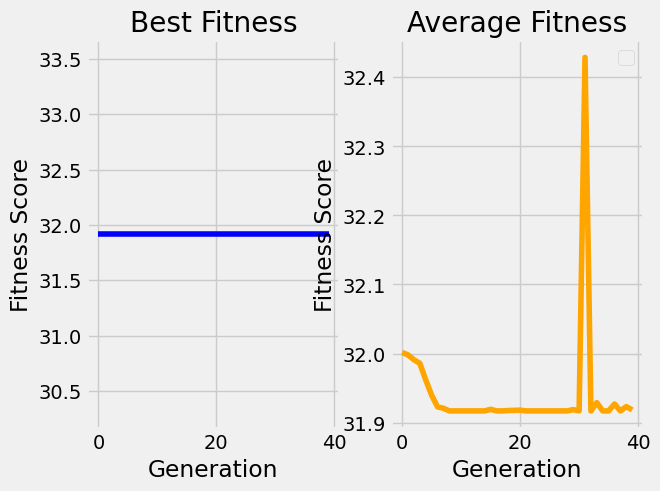

In [220]:
generation = genetic_algorithm(generation_with_fitness, 0.01, 0)
metrics = {'min': [], 'max': [], 'mean': []}

for i in range(0, 500):
    generation_with_fitness = add_fitness_to_generation(generation)
    metric = get_metrics_from_generation(generation_with_fitness)
    generation = genetic_algorithm(generation_with_fitness, 0.01, 0)

    # Add the metric to the list of metrics
    metrics['min'].append(metric['min'])
    metrics['mean'].append(metric['mean'])

    # Print the metrics
    print("Generation", i + 1)
    print("Best Fitness:", metric['min'])
    print("Average Fitness:", metric['mean'])

# Plot best fitness score evolution
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.title('Best Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.plot(metrics['min'], color='blue')

# Plot the average fitness score evolution
plt.subplot(1, 2, 2)
plt.title('Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.plot(metrics['mean'], color='orange')

# Display the plots
plt.legend()
plt.show()

